In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import fuzzywuzzy
from fuzzywuzzy import process
import charset_normalizer
from datetime import datetime


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/video-game-sales-2024/vgchartz-2024.csv


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# LETS UPLOAD THE DATA AND MAKE THE FIRST NECESSARY MANIPULATIONS


In [2]:
#upload the file
raw_df = pd.read_csv('/kaggle/input/video-game-sales-2024/vgchartz-2024.csv')

In [3]:
#check the head
raw_df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaN
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,NaN
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14


In [4]:
#Check the data types
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img           64016 non-null  object 
 1   title         64016 non-null  object 
 2   console       64016 non-null  object 
 3   genre         64016 non-null  object 
 4   publisher     64016 non-null  object 
 5   developer     63999 non-null  object 
 6   critic_score  6678 non-null   float64
 7   total_sales   18922 non-null  float64
 8   na_sales      12637 non-null  float64
 9   jp_sales      6726 non-null   float64
 10  pal_sales     12824 non-null  float64
 11  other_sales   15128 non-null  float64
 12  release_date  56965 non-null  object 
 13  last_update   17879 non-null  object 
dtypes: float64(6), object(8)
memory usage: 6.8+ MB


In [5]:
#We can drop two columns - image and last update, since they are not too relevant for data analysis
raw_df.drop(['last_update', 'img'], axis=1, inplace=True)

In [6]:
#check the result
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         64016 non-null  object 
 1   console       64016 non-null  object 
 2   genre         64016 non-null  object 
 3   publisher     64016 non-null  object 
 4   developer     63999 non-null  object 
 5   critic_score  6678 non-null   float64
 6   total_sales   18922 non-null  float64
 7   na_sales      12637 non-null  float64
 8   jp_sales      6726 non-null   float64
 9   pal_sales     12824 non-null  float64
 10  other_sales   15128 non-null  float64
 11  release_date  56965 non-null  object 
dtypes: float64(6), object(6)
memory usage: 5.9+ MB


In [7]:
#also we immediately need to transform release_date from object to data format
raw_df['release_date'] = pd.to_datetime(raw_df['release_date'], errors='coerce')

# LET'S ANALYZE THE NULLS AND DO THE FIRST CLEANING


In [8]:
#We see that some data is missing, but we need to know how much exactly
missing_values_count = raw_df.isnull().sum().sort_values(ascending=False)
print(missing_values_count)

critic_score    57338
jp_sales        57290
na_sales        51379
pal_sales       51192
other_sales     48888
total_sales     45094
release_date     7051
developer          17
title               0
console             0
genre               0
publisher           0
dtype: int64


Text(0, 0.5, 'Number of NaNs')

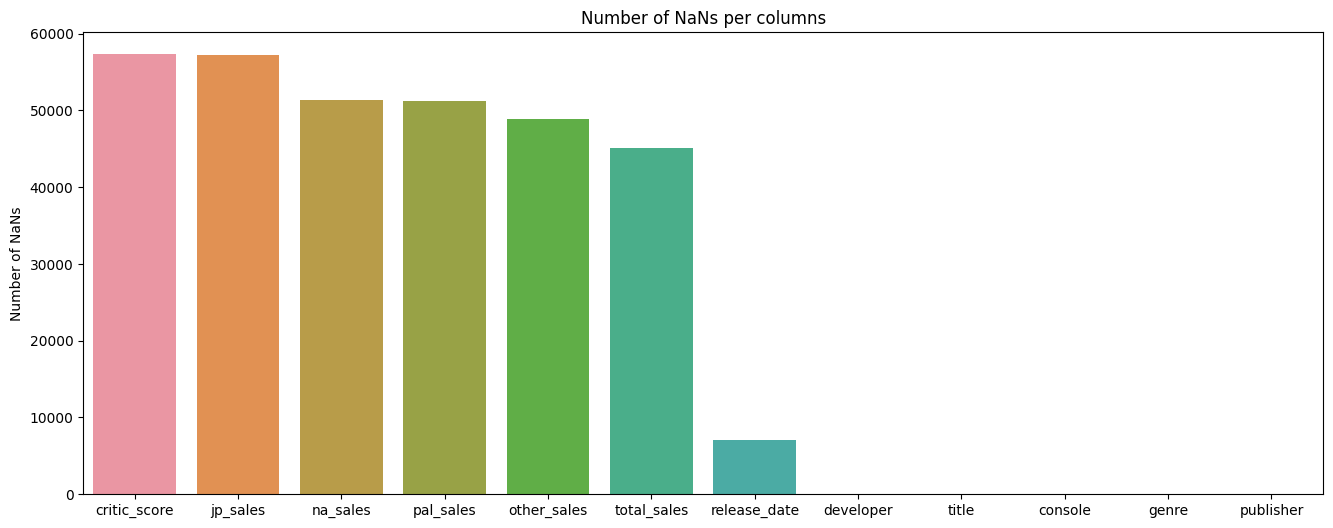

In [9]:
#Let's do visual to see the columns with high numbers of NaNs
# Set the width and height of the figure
plt.figure(figsize=(16,6))

# Add title
plt.title("Number of NaNs per columns")

# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(x=missing_values_count.index, y=missing_values_count)

# Add label for vertical axis
plt.ylabel("Number of NaNs")

In [10]:
#as we see, the NaN with release dates are around 10%, so let's see it randomly

raw_df.loc[(raw_df['release_date'].isnull())]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date
595,Gran Turismo Concept 2001 Tokyo,PS2,Racing,Unknown,Polyphony Digital,NaN,1.84,NaN,0.42,1.10,0.33,NaT
4016,TERA,PC,Role-Playing,Unknown,En Masse,NaN,0.42,0.25,NaN,0.13,0.04,NaT
4662,Dragon Ball Z: Budokai Tenkaichi 2 (JP sales),Wii,Action,Unknown,Unknown,NaN,0.35,0.15,0.14,0.05,0.01,NaT
4846,Custom Robo,N64,Fighting,Unknown,Noise Inc.,NaN,0.33,NaN,0.29,NaN,0.04,NaT
6075,Jonah Lomu Rugby Challenge,PS3,Sports,Home Entertainment Suppliers,Sidhe Interactive,NaN,0.25,NaN,NaN,0.20,0.05,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
63982,The Wreck,PC,Visual Novel,Unknown,The Pixel Hunt,NaN,NaN,NaN,NaN,NaN,NaN,NaT
63983,The Wreck,PS4,Visual Novel,Unknown,The Pixel Hunt,NaN,NaN,NaN,NaN,NaN,NaN,NaT
63984,The Wreck,PS5,Visual Novel,Unknown,The Pixel Hunt,NaN,NaN,NaN,NaN,NaN,NaN,NaT
64003,Witch on the Holy Night,NS,Visual Novel,Unknown,Type-Moon,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [11]:
#so, certain games with no release_date generate sales. In order not to delete something important for Data Analysis, 
#we need to make it as NaN for release_date AND NaN for all categories of sales
raw_df.loc[(raw_df['release_date'].isnull() & raw_df['total_sales'].isnull() & raw_df['na_sales'].isnull() & raw_df['jp_sales'].isnull() & raw_df['pal_sales'].isnull() & raw_df['other_sales'].isnull())]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date
19006,How to Survive 2,PC,Action,Unknown,EKO Software,NaN,NaN,NaN,NaN,NaN,NaN,NaT
19066,Geometry Dash,PC,Action,Unknown,RobTop Games,NaN,NaN,NaN,NaN,NaN,NaN,NaT
19069,Who's Your Daddy,PC,Action,Unknown,Evil Tortilla Games,NaN,NaN,NaN,NaN,NaN,NaN,NaT
19093,Super Hexagon,PC,Action,Unknown,Terry Cavanagh,NaN,NaN,NaN,NaN,NaN,NaN,NaT
19117,Warhammer: Vermintide 2,PC,Action,Unknown,Fatshark AB,NaN,NaN,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
63982,The Wreck,PC,Visual Novel,Unknown,The Pixel Hunt,NaN,NaN,NaN,NaN,NaN,NaN,NaT
63983,The Wreck,PS4,Visual Novel,Unknown,The Pixel Hunt,NaN,NaN,NaN,NaN,NaN,NaN,NaT
63984,The Wreck,PS5,Visual Novel,Unknown,The Pixel Hunt,NaN,NaN,NaN,NaN,NaN,NaN,NaT
64003,Witch on the Holy Night,NS,Visual Novel,Unknown,Type-Moon,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [12]:
#So we need to drop just those rows
raw_df = raw_df.loc[~((raw_df['release_date'].isnull()) & (raw_df['total_sales'].isnull()) & (raw_df['na_sales'].isnull()) & (raw_df['jp_sales'].isnull()) & (raw_df['pal_sales'].isnull()) & (raw_df['other_sales'].isnull()))]

In [13]:
#Let's check the result. It's successful and we could leave the remaining null release_dates for the time being, but we will come back to them later!
raw_df.isnull().sum().sort_values(ascending=False)

critic_score    50418
jp_sales        50329
na_sales        44418
pal_sales       44231
other_sales     41927
total_sales     38133
release_date       90
developer          12
title               0
console             0
genre               0
publisher           0
dtype: int64

# LET'S REPLACE NULLS STEP BY STEP

> **DEVELOPER**

In [14]:
#Start with developer, there are only twelve NaNs
raw_df.loc[(raw_df['developer'].isnull())]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date
8486,Gourmet Chef: Cook Your Way to Fame,DS,Misc,Ubisoft,NaN,NaN,0.14,0.13,NaN,NaN,0.01,2008-06-24
10832,Wordmaster,DS,Strategy,"Destination Software, Inc",NaN,NaN,0.09,0.09,NaN,0.0,0.01,2008-08-12
18185,SAS: Secure Tomorrow,PC,Shooter,City Interactive,NaN,NaN,0.00,NaN,NaN,0.0,0.00,2008-10-16
18455,My Baby and Me,Wii,Misc,Unknown,NaN,NaN,0.00,NaN,NaN,0.0,NaN,NaT
19925,Bounty Hunter,PC,Action,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-11-30
25045,Abandoner,PC,Adventure,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004-09-17
27407,The Enchanted Unicorn,PC,Adventure,Take-Two Interactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-09-16
31230,istanbul Beyleri,PC,Fighting,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-12-17
37057,Purrfect Pet Shop,PC,Misc,eGames,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-06-13
55431,My Friend Pedro,NS,Shooter,Devolver Digital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-20


In [15]:
#fillin the necessary information
raw_df.loc[(raw_df['title'] == 'Gourmet Chef: Cook Your Way to Fame'), 'developer'] = 'Creative Patterns'
raw_df.loc[(raw_df['title'] == 'Wordmaster'), 'developer'] = 'Sarbakan'
raw_df.loc[(raw_df['title'] == 'SAS: Secure Tomorrow'), 'developer'] = 'City Interactive'
raw_df.loc[(raw_df['title'] == 'My Baby and Me'), 'developer'] = 'Sonic Powered'
#drop the rows where the publisher is unknownn and developer is NaN
raw_df = raw_df.loc[~((raw_df['publisher'] == "Unknown") & (raw_df['developer'].isnull()))]
#drop the remaining five rows
raw_df.drop(index=[27407,37057,55431,55432,62494], inplace=True)


In [16]:
#check the results
raw_df.loc[(raw_df['developer'].isnull())]

,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date


# LET'S SORT OUT THE SALES SITUATION

In [17]:
#Let's check where all sales data is missing
raw_df.loc[(raw_df['total_sales'].isnull() & raw_df['na_sales'].isnull() & raw_df['jp_sales'].isnull() & raw_df['pal_sales'].isnull() & raw_df['other_sales'].isnull())]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date
18922,God of War,Series,Action,Sony Interactive Entertainment,SIE Santa Monica Studio,NaN,NaN,NaN,NaN,NaN,NaN,2005-03-22
18923,Warriors,Series,Action,KOEI,Omega Force,NaN,NaN,NaN,NaN,NaN,NaN,1997-06-30
18924,Devil May Cry,Series,Action,Capcom,Capcom,NaN,NaN,NaN,NaN,NaN,NaN,2001-10-16
18925,God of War (2018),All,Action,Sony Interactive Entertainment,SIE Santa Monica Studio,NaN,NaN,NaN,NaN,NaN,NaN,2018-04-20
18926,Dynasty Warriors,Series,Action,KOEI,Omega Force,NaN,NaN,NaN,NaN,NaN,NaN,1997-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...
64010,World End Syndrome,PS4,Visual Novel,Arc System Works,Arc System Works,NaN,NaN,NaN,NaN,NaN,NaN,2018-04-26
64011,XBlaze Lost: Memories,PC,Visual Novel,Aksys Games,Arc System Works,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-11
64012,"Yoru, Tomosu",PS4,Visual Novel,Nippon Ichi Software,Nippon Ichi Software,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-30
64013,"Yoru, Tomosu",NS,Visual Novel,Nippon Ichi Software,Nippon Ichi Software,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-30


In [18]:
#drop them
raw_df = raw_df.loc[~((raw_df['total_sales'].isnull() & raw_df['na_sales'].isnull() & raw_df['jp_sales'].isnull() & raw_df['pal_sales'].isnull() & raw_df['other_sales'].isnull()))]

> **Zero out sales columns, if total_sales is zero**

In [19]:
raw_df.isnull().sum().sort_values(ascending=False)

critic_score    14796
jp_sales        12196
na_sales         6285
pal_sales        6098
other_sales      3794
release_date       90
title               0
console             0
genre               0
publisher           0
developer           0
total_sales         0
dtype: int64

In [20]:
#We need to devise a way that will fill in the numeric values and apply it. First we will zero the values, if the total_sales figure is zero
raw_df.loc[(raw_df['na_sales'] == 0.0)]

#Let's do it with lambdas
raw_df['na_sales'] = raw_df.apply(lambda row: 0 if row['total_sales'] == 0.0 else row['na_sales'], axis=1)
raw_df['jp_sales'] = raw_df.apply(lambda row: 0 if row['total_sales'] == 0.0 else row['jp_sales'], axis=1)
raw_df['pal_sales'] = raw_df.apply(lambda row: 0 if row['total_sales'] == 0.0 else row['pal_sales'], axis=1)
raw_df['other_sales'] = raw_df.apply(lambda row: 0 if row['total_sales'] == 0.0 else row['other_sales'], axis=1)



In [21]:
#Let's check the result and we did it right
raw_df.loc[(raw_df['total_sales'] == 0.0) & (raw_df['na_sales'] == 0.0)]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date
17570,Zero Escape: Virtue's Last Reward,PSV,Visual Novel,Aksys Games,ChunSoft,NaN,0.0,0.0,0.0,0.0,0.0,2012-10-23
17571,Daitoshokan no Hitsujikai: Library Party,NS,Visual Novel,Aria,August,NaN,0.0,0.0,0.0,0.0,0.0,2018-07-26
17572,Cendrillon palikA,NS,Visual Novel,Idea Factory,Otomate,NaN,0.0,0.0,0.0,0.0,0.0,2018-10-25
17573,Sanzen Sekai Yuugi: Re Multi Universe Myself,PSV,Visual Novel,Dramatic Create,girls dynamics,NaN,0.0,0.0,0.0,0.0,0.0,2018-09-27
17574,Clannad,PS4,Visual Novel,Prototype,Prototype,NaN,0.0,0.0,0.0,0.0,0.0,2018-06-14
...,...,...,...,...,...,...,...,...,...,...,...,...
18917,Teslagrad,WiiU,Platform,Rain Games,Rain Games,7.0,0.0,0.0,0.0,0.0,0.0,2014-09-11
18918,Open Season,XB,Platform,Ubisoft,Ubisoft Montreal,6.4,0.0,0.0,0.0,0.0,0.0,2006-09-19
18919,The SpongeBob SquarePants Movie,PC,Platform,THQ,Heavy Iron Studios,6.0,0.0,0.0,0.0,0.0,0.0,2004-10-27
18920,Santa Claus Saves the Earth,GBA,Platform,Telegames,Ivolgamus UAB,NaN,0.0,0.0,0.0,0.0,0.0,2002-10-30


> Move to different categories of sales

In [22]:
raw_df.isnull().sum().sort_values(ascending=False)

critic_score    14796
jp_sales        11095
pal_sales        5788
na_sales         5115
other_sales      3429
release_date       90
title               0
console             0
genre               0
publisher           0
developer           0
total_sales         0
dtype: int64

In [23]:
#Check na_sales
raw_df.loc[(raw_df['na_sales'].isnull())]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date
499,Famista '89 - Kaimaku Han!!,NES,Sports,Namco,Namco,NaN,2.05,NaN,2.05,NaN,NaN,1989-07-28
580,SingStar,PS2,Misc,Sony Computer Entertainment,SCEE London Studio,8.0,1.86,NaN,NaN,1.37,0.49,2004-05-21
595,Gran Turismo Concept 2001 Tokyo,PS2,Racing,Unknown,Polyphony Digital,NaN,1.84,NaN,0.42,1.10,0.33,NaT
604,Dragon Quest XI,3DS,Role-Playing,Square Enix,Square Enix,NaN,1.82,NaN,1.82,NaN,NaN,2017-07-29
667,Super Puyo Puyo,SNES,Puzzle,Banpresto,Compile,NaN,1.70,NaN,1.69,NaN,0.01,1993-12-10
...,...,...,...,...,...,...,...,...,...,...,...,...
17565,Root Double: Before Crime * After Days,X360,Visual Novel,Yeti,Yeti,NaN,0.01,NaN,0.01,NaN,NaN,2012-06-14
17566,Gakuen Hetalia,DS,Visual Novel,Idea Factory,Idea Factory,NaN,0.01,NaN,0.01,NaN,NaN,2012-03-08
17567,Chaos;Child: Love Chu Chu!!,PSV,Visual Novel,5pb,5pb. Inc.,NaN,0.01,NaN,0.01,NaN,NaN,2017-03-30
17568,Doukoku Soshite... Doukoku Soshite...,PS4,Visual Novel,El Dia,El Dia,NaN,0.01,NaN,0.01,NaN,NaN,2018-04-26


In [24]:
#So, we need to zero out all the remaining values
raw_df['na_sales'] = raw_df['na_sales'].replace(np.nan, 0)
raw_df['jp_sales'] = raw_df['jp_sales'].replace(np.nan, 0)
raw_df['pal_sales'] = raw_df['pal_sales'].replace(np.nan, 0)
raw_df['other_sales'] = raw_df['other_sales'].replace(np.nan, 0)


In [25]:
raw_df.loc[(raw_df['title'] == "Gran Turismo Concept 2001 Tokyo")]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date
595,Gran Turismo Concept 2001 Tokyo,PS2,Racing,Unknown,Polyphony Digital,NaN,1.84,0.0,0.42,1.1,0.33,NaT


In [26]:
#Check the result
raw_df.isnull().sum().sort_values(ascending=False)

critic_score    14796
release_date       90
title               0
console             0
genre               0
publisher           0
developer           0
total_sales         0
na_sales            0
jp_sales            0
pal_sales           0
other_sales         0
dtype: int64

# Let's move to critic_score

In [27]:
raw_df.loc[(raw_df['critic_score'].isnull())]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date
3,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17
23,Halo 4,X360,Shooter,Microsoft Studios,343 Industries,NaN,9.96,6.72,0.04,2.36,0.83,2012-11-06
25,Call of Duty: Black Ops IIII,PS4,Shooter,Activision,Treyarch,NaN,9.32,4.05,0.50,3.28,1.49,2018-10-12
26,FIFA 19,PS4,Sports,Electronic Arts,EA Sports,NaN,9.15,0.84,0.10,6.87,1.34,2018-09-28
33,FIFA 13,PS3,Sports,EA Sports,EA Canada,NaN,8.01,1.07,0.13,5.13,1.68,2012-09-25
...,...,...,...,...,...,...,...,...,...,...,...,...
18914,D.S.: Dal Segno,PSV,Visual Novel,Entergram,Entergram,NaN,0.00,0.00,0.00,0.00,0.00,2018-03-22
18915,Hello Lady! Superior Dynamis,PSV,Visual Novel,Dramatic Create,Dramatic Create,NaN,0.00,0.00,0.00,0.00,0.00,2018-01-25
18916,Teslagrad,PSV,Platform,Rain Games,Rain Games,NaN,0.00,0.00,0.00,0.00,0.00,2014-10-28
18920,Santa Claus Saves the Earth,GBA,Platform,Telegames,Ivolgamus UAB,NaN,0.00,0.00,0.00,0.00,0.00,2002-10-30


In [28]:
#let's make groupby with critic_scores and analyze it
median_score = raw_df.groupby(["title"])["critic_score"].mean()
print(median_score.isnull())

title
'98 Koshien                                 True
.hack//G.U. Last Recode                     True
.hack//G.U. Vol.2//Reminisce               False
.hack//G.U. Vol.2//Reminisce (jp sales)     True
.hack//G.U. Vol.3//Redemption              False
                                           ...  
thinkSMART Kids 8+                          True
thinkSMART: Chess for Kids                  True
uDraw Studio                                True
uDraw Studio: Instant Artist                True
¡Shin Chan Flipa en colores!                True
Name: critic_score, Length: 12992, dtype: bool


In [29]:
#what is the percentage of missing values
total_cells = np.product(median_score.shape)
total_missing = median_score.isnull().sum()

#what is the percentage
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

77.86330049261085


In [30]:
#We need to fill in the positive values into the table
raw_df['critic_score'] = raw_df.groupby('title')['critic_score'].transform(lambda x: x.fillna(x.mean()))

In [31]:
#Let's check
raw_df.isnull().sum().sort_values(ascending=False)

critic_score    13210
release_date       90
title               0
console             0
genre               0
publisher           0
developer           0
total_sales         0
na_sales            0
jp_sales            0
pal_sales           0
other_sales         0
dtype: int64

In [32]:
#The rest we cannot find by the means of median scores for games, so we replace them with Nones
raw_df = raw_df.replace(np.nan, "None")


In [33]:
#Voila, the job is done!
raw_df.isnull().sum().sort_values(ascending=False)

title           0
console         0
genre           0
publisher       0
developer       0
critic_score    0
total_sales     0
na_sales        0
jp_sales        0
pal_sales       0
other_sales     0
release_date    0
dtype: int64